In [118]:
# -- ObjectWarnings.ipynb --
# Version vom 17.11.2021 by LF
# ----------------------------

import os
import yaml

# create 'relative' path to file
dirname = os.getcwd()
filename = dirname.replace('scripts', 'config/StatusToTurtleTwist.yaml')
save_fig = dirname.replace('scripts', 'appendix/Sicherheitsfunktionen.png')

with open(filename, "r") as stream:
    try:
        yaml_file = (yaml.safe_load(stream))
        distances = yaml_file['distance']
    except yaml.YAMLError as exc:
        print(exc)

min_dist = distances.get('min')           # min Laserscan
max_dist = distances.get('max')           # max Laserscan
crit_dist = distances.get('critical')     # kritischer Abstand
n = distances.get('n')

In [119]:
# Lineare Funktion über 2 Punkte bestimmen:
# f(x) = (y_2-y_1)/(x_2-x_1) * (x-x_1) + y_1
# round(f(x), 2) --> Funktionswert runden (2 FloatingPoints)
# max(min(1, f(x)), 0) --> 0 <= f(x) <= 1

r = 5  # round

# red(x) = (0-1)/(max-min) * (x-min) + 1
red_func = lambda x: max(min(1, round(-1/(max_dist-min_dist)*(x-min_dist)+1, r)), 0)

# green(x) = (1-0)/(max-min) * (x-min) + 0
green_func = lambda x: max(min(1, round(1/(max_dist-min_dist)*(x-min_dist)+0, r)), 0)

# rumble(x) = (0-1)/(crit-min) * (x-min) + 1
rumble_func = lambda x: max(min(1, round(-1/(crit_dist-min_dist)*(x-min_dist)+1, r)), 0)

# Geschwindigkeit nach Vorne begrenzen / blockieren
# 1/n der kritischen Distanz --> linear.x = 50%; darunter 0%
# reduce_vel(x) = (1-0.5)/((crit/n)-crit) * (x-(crit/n)) + 0.5
def reduce_vel(x):

    if x <= crit_dist/n:
        return 0
    elif x > crit_dist/3 and x <= crit_dist:
        p = (0.5/(crit_dist/n)) * (x-(crit_dist/n)) + 0.5
        p = round(p, r)
        p = max(min(1, p), 0.5)
        return p
    else:
        return 1

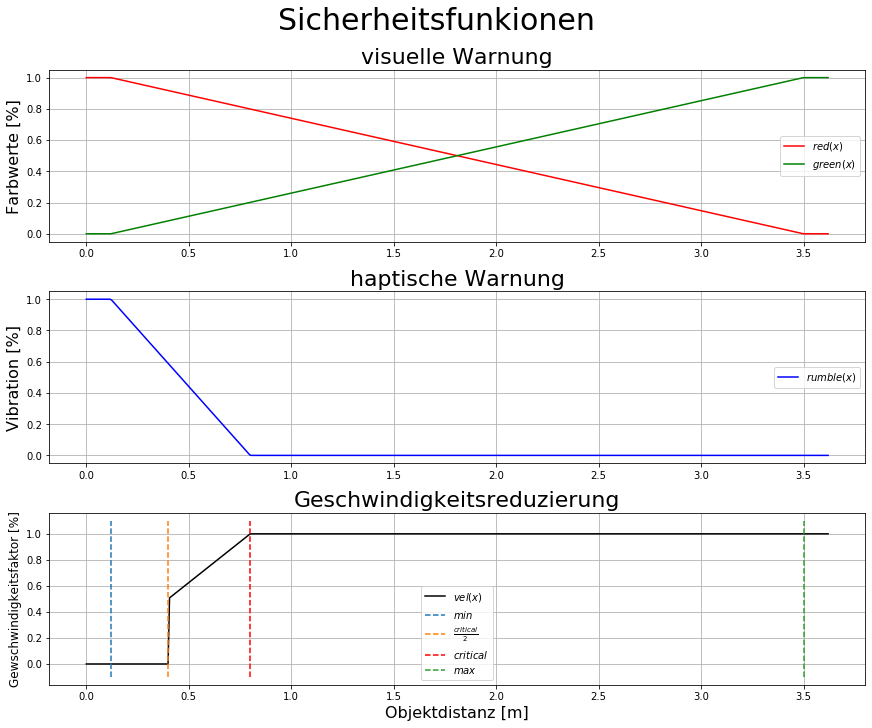

In [125]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, max_dist+min_dist, 500)

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(12,10))
fig.suptitle('Sicherheitsfunkionen', fontsize=30)

red = []
green = []
rumble = []
vel = []
for x_i in x:
    red.append(red_func(x_i))
    green.append(green_func(x_i))
    rumble.append(rumble_func(x_i))
    vel.append(reduce_vel(x_i))


axs[0].plot(x,red, '-r', label='$red(x)$')
axs[0].plot(x,green, '-g', label='$green(x)$')
axs[0].set_title('visuelle Warnung', fontsize=22)
axs[0].set_ylabel('Farbwerte [%]', fontsize=16)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].plot(x,rumble, 'b', label='$rumble(x)$')
axs[1].set_title('haptische Warnung', fontsize=22)
axs[1].set_ylabel('Vibration [%]', fontsize=16)
axs[1].legend(loc=5)
axs[1].grid()

axs[2].plot(x,vel, '-k', label='$vel(x)$')
axs[2].plot([min_dist,min_dist],[-0.1,1.1], '--', label='$min$')
critical_string = r"$\frac{critical}{%s}$" % n
axs[2].plot([crit_dist/2,crit_dist/2],[-0.1,1.1], '--', label=critical_string)
axs[2].plot([crit_dist,crit_dist],[-0.1,1.1], '--r', label='$critical$')
axs[2].plot([max_dist,max_dist],[-0.1,1.1], '--', label='$max$')
axs[2].set_title('Geschwindigkeitsreduzierung', fontsize=22)
axs[2].set_xlabel('Objektdistanz [m]', fontsize=16)
axs[2].set_ylabel('Gewschwindigkeitsfaktor [%]', fontsize=12)
axs[2].legend(loc='best')
axs[2].grid()

plt.savefig(save_fig)